In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
np.set_printoptions(precision = 2)

In [2]:
path_clean_power = "./data/clean_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

In [3]:
dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str}
usecols = [name for name, _ in dtypes.items()]

In [4]:
household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)

In [5]:
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)
market.set_index("date", inplace = True)

In [6]:
market.interpolate(method = "time", axis = 0, inplace = True)

In [7]:
household.head()

,date_valid_to,date_valid_from,post_code,consumption_range_kwh,price_year_eur
0,2021-09-01,2021-06-02,14480,3500,878.86
1,2021-09-01,2021-06-09,14480,2800,678.69
2,2021-09-01,2021-07-10,14480,7500,2022.68
3,2021-09-01,2021-07-10,14480,7800,2108.47
4,2021-09-01,2021-07-10,14480,8000,2165.66


In [7]:
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]

In [8]:
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])

In [10]:
print(f"Earliest date: {household['date_valid_from'].min()}" +
f"Latest date: {household['date_valid_to'].max()}")

Earliest date: 2021-05-25 00:00:00Latest date: 2022-10-15 00:00:00


In [9]:
postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [33]:
consRanges

array([ 3500,  2800,  7500,  7800,  8000,  8500,  9000,  4000,  4500,
        5000,  6500,  7000,  9500,   250, 20000,  4250,  6000,  2400,
        5500, 12000, 10000,  1200,  2500,  3000,  3600,  5600,   500,
        1000,  2000,  1500], dtype=int32)

In [12]:
household.head()

,date_valid_to,date_valid_from,post_code,consumption_range_kwh,price_year_eur,price_kwh
0,2021-09-01,2021-06-02,14480,3500,878.86,0.251103
1,2021-09-01,2021-06-09,14480,2800,678.69,0.242389
2,2021-09-01,2021-07-10,14480,7500,2022.68,0.269691
3,2021-09-01,2021-07-10,14480,7800,2108.47,0.270317
4,2021-09-01,2021-07-10,14480,8000,2165.66,0.270707


In [10]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737") -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [37]:
#Create Multi-ConsRange model input
df = pd.DataFrame()
for cr in consRanges:
    ps = queryRangePostCode(household, int(cr), "81737")
    ps["consumption_range_kwh"] = cr
    df = pd.concat([df, ps])
input = df.join(market[["spot", "d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]])
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [48]:
input.loc["2022-10-10"]

,price_kwh,consumption_range_kwh,spot,d01,d02,M01,M02,M03,q01,q02,y01,y02
2022-10-10,0.820559,3500,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.833977,2800,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.913274,7500,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.916905,7800,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.938145,8000,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.938169,8500,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.938190,9000,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.827667,4000,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.824321,4500,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0
2022-10-10,0.838382,5000,162.09,259.87,301.67,344.89,390.41,547.93,484.09,363.0,427.0,270.0


In [20]:
df = queryRangePostCode(household, 3500, "81737")
input = df.join(market[["spot", "d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [21]:
input

,price_kwh,spot,d01,d02,M01,M02,M03,q01,q02,y01,y02
valid_range,,,,,,,,,,,
2021-08-03,0.280969,0.096510,0.09817,0.09389,0.09125,0.09178,0.09851,0.09459,0.09005,0.07610,0.06640
2021-08-04,0.280969,0.098169,0.09451,0.07220,0.09098,0.09206,0.09850,0.09475,0.09053,0.07658,0.06668
2021-08-05,0.280969,0.094510,0.07160,0.06487,0.09139,0.09240,0.09946,0.09528,0.09119,0.07705,0.06705
2021-08-06,0.280969,0.071597,0.06152,0.01190,0.09330,0.09475,0.10155,0.09710,0.09403,0.07903,0.06873
2021-08-07,0.280969,0.061515,0.00563,0.06759,0.09248,0.09393,0.10132,0.09690,0.09434,0.07914,0.06919
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09,0.820559,0.146725,0.16209,0.25987,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-10,0.820559,0.162090,0.25987,0.30167,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-11,0.832090,0.259874,0.28254,0.25562,0.34531,0.38275,0.56462,0.50137,0.37100,0.43564,0.27000


<AxesSubplot: xlabel='valid_range'>

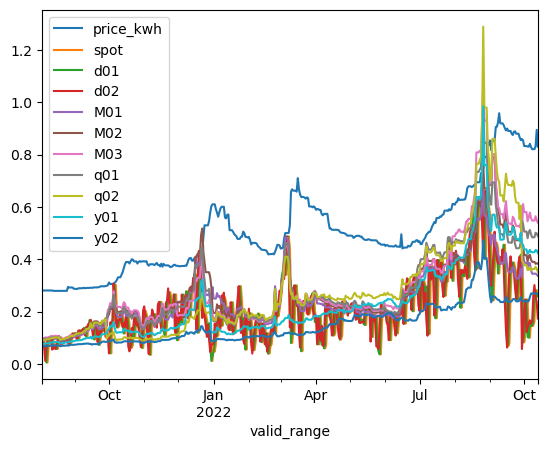

In [23]:
input.plot()

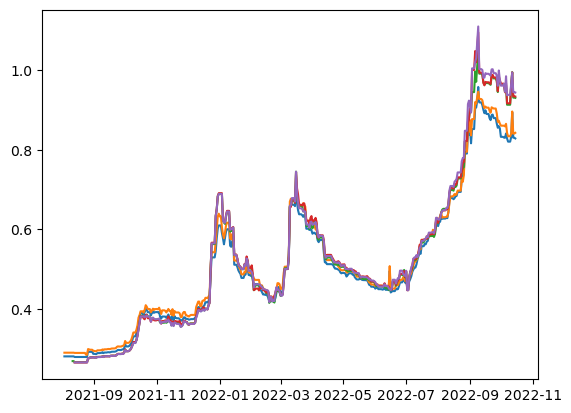

In [16]:
dfs = [(x, queryRangePostCode(household, x, "81737")) for x in consRanges[0:5]]
for _, df in dfs:
    plt.plot(df)
    

In [17]:
df.head()

,price_kwh
valid_range,
2021-08-13,0.26583
2021-08-14,0.26583
2021-08-15,0.26583
2021-08-16,0.26583
2021-08-17,0.26583


In [18]:
market.head()

,spot,d00,d01,d02,d03,d04,d05,d06,w00,w01,...,q04,q05,q06,q07,y01,y02,y03,y04,y05,y06
date,,,,,,,,,,,,,,,,,,,,,
2017-07-01,28.445000,28.45,24.18,32.42,34.89,38.70,39.120,38.500000,32.84,34.56,...,28.55,32.37,31.84,25.36,31.05,28.26,28.35,29.57,30.54,31.39
2017-07-02,24.175000,24.18,32.42,34.89,38.70,39.12,38.500,38.333333,32.84,34.56,...,28.55,32.37,31.84,25.36,31.05,28.26,28.35,29.57,30.54,31.39
2017-07-03,32.421250,32.42,34.89,38.70,39.12,38.50,33.625,38.166667,32.84,34.56,...,28.55,32.37,31.84,25.36,31.05,28.26,28.35,29.57,30.54,31.39
2017-07-04,34.887083,34.89,38.84,38.75,38.50,33.25,28.750,38.000000,35.06,34.39,...,28.63,32.82,32.06,25.57,31.29,28.46,28.55,29.73,30.70,31.55
2017-07-05,38.835417,38.84,39.36,38.00,33.25,29.49,37.440,36.690000,35.18,33.33,...,28.78,32.69,32.17,25.74,31.31,28.55,28.67,29.89,30.86,31.71


In [19]:
hh_av = pd.DataFrame(pd.date_range("2021-05-25", "2022-10-15"), columns=["date"])
hh_av["av_price_kwh"] = 0
hh_av["counter"] = 0
hh_av.head()

,date,av_price_kwh,counter
0,2021-05-25,0,0
1,2021-05-26,0,0
2,2021-05-27,0,0
3,2021-05-28,0,0
4,2021-05-29,0,0


In [ ]:
for row in household.index:
    for day in pd.date_range(household.date_valid_from.iloc[row], household.date_valid_to.iloc[row]):
        hh_av_row = hh_av.loc[hh_av["date"] == day].index
        hh_av.loc[hh_av_row,"av_price_kwh"] += household.loc[row, "price_kwh"]
        hh_av.loc[hh_av_row, "counter"] += 1

hh_av["av_price_kwh"] = hh_av["av_price_kwh"]/hh_av["counter"]

# Data Wrangling

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [ ]:
def getXValues(date, df = market):
    try:
        date = pd.to_datetime(date)
    except:
        raise ValueError("Incorrect Date Format")

    delta = lambda x: pd.Timedelta(x, "days")
    df = df.loc[date - delta(20) : date - delta(1)]
    df = df.filter(["spot", "d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"])
    
    return df

In [ ]:
data = np.array([getXValues(df.iloc[i,].name).values for i in np.arange(len(df))])
data[23]


/tmp/ipykernel_3881/71968298.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([getXValues(df.iloc[i,].name).values for i in np.arange(len(df))])


array([[  5.63,  67.59,  90.77,  92.48,  93.93, 101.32,  96.9 ,  94.34,
         79.14,  69.19],
       [ 67.59,  90.77, 101.53,  92.48,  93.93, 101.32,  96.9 ,  94.34,
         79.14,  69.19],
       [ 90.77, 100.76, 102.04,  94.9 ,  96.4 , 103.75,  99.71,  96.76,
         80.49,  69.74],
       [100.76, 106.54,  98.47,  96.01,  97.84, 106.06, 101.37,  98.71,
         81.93,  70.23],
       [106.54,  94.9 ,  55.33,  96.69,  98.69, 107.59, 102.41,  99.96,
         83.41,  70.84],
       [ 94.9 ,  63.37,  57.79,  94.36,  96.45, 105.  , 100.08,  98.72,
         82.07,  70.05],
       [ 63.37,  61.94,  67.6 ,  97.11,  99.55, 107.8 , 103.26, 101.75,
         84.47,  71.12],
       [ 61.94,  67.6 ,  57.39,  97.11,  99.55, 107.8 , 103.26, 101.75,
         84.47,  71.12],
       [ 67.6 ,  57.39,  82.08,  97.11,  99.55, 107.8 , 103.26, 101.75,
         84.47,  71.12],
       [ 57.39,  78.64,  92.36,  97.37,  99.48, 106.5 , 102.63, 101.61,
         84.76,  71.25],
       [ 78.64,  91.62, 107.67

In [ ]:
data.shape

(437,)

In [ ]:
dataset = timeseries_dataset_from_array(data, df, 20)

In [ ]:
getXValues(df.iloc[200,].name)

,spot,d01,d02,M01,M02,M03,q01,q02,y01,y02
date,,,,,,,,,,
2021-12-29,155.603333,73.26,46.07,236.76,331.67,238.78,267.00,193.80,219.88,125.14
2021-12-30,73.262083,12.13,75.33,221.44,293.65,210.40,172.76,176.65,120.11,87.03
2021-12-31,12.127917,29.74,75.72,293.65,210.40,188.97,172.76,176.65,120.11,87.03
2022-01-01,82.578333,47.35,76.11,250.00,195.00,175.44,163.03,168.00,121.63,89.20
2022-01-02,47.353750,76.11,153.92,250.00,195.00,175.44,163.03,168.00,121.63,89.20
2022-01-03,76.107083,153.92,105.90,250.00,195.00,175.44,163.03,168.00,121.63,89.20
2022-01-04,153.916667,107.87,185.03,271.00,228.17,203.46,193.63,199.50,139.88,96.89
2022-01-05,107.868333,194.10,171.03,257.10,214.33,195.99,183.93,189.25,134.70,96.34
2022-01-06,194.097500,167.18,153.33,260.00,221.70,198.67,186.58,191.00,133.00,94.85


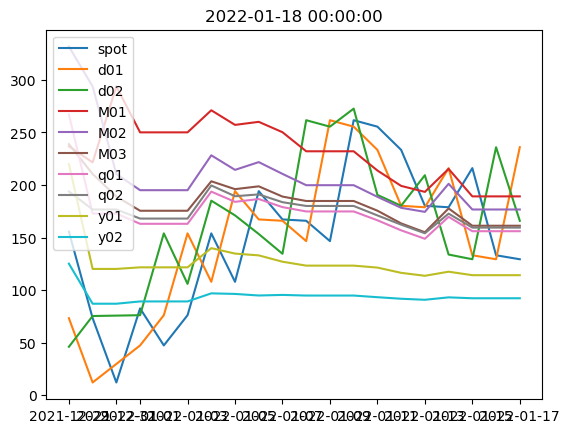

In [ ]:
date = df.iloc[200,].name
data = getXValues(date)
plt.plot(data, label = data.columns)
plt.title(str(date))
plt.legend()

In [ ]:
def getXValuesNP(df):
    x = []
    for date in df.index:
        x[,,i] = 


In [ ]:
x = np.ndarray(shape=(20,10,len(df)))
x.shape

(20, 10, 471)

# Neural Network Build

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2023-01-10 11:45:26.711712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
rnn = tf.keras.Sequential()
rnn.add(layers.Input(shape = (20,10,)))
rnn.add(layers.LSTM(units = 20))
rnn.add(layers.Dense(20))
rnn.add(layers.Dense(1, activation = "sigmoid"))


In [ ]:
rnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
rnn.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 20)                2080      
                                                                 
 dense_26 (Dense)            (None, 20)                420       
                                                                 
 dense_27 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn.fit(getXyValues(), epochs=5)

TypeError: getXyValues() missing 1 required positional argument: 'call'